In [1]:
#!unzip data_sample_no_smarmellata.zip

# Seegmentazione 55 classi
- Dataset A2D2 from audi
- lavora con immagini 256x256x3 (RGB)
- ritorna 256x256x55 (55 classi)

# To do:
- custom loss
- rete custom (resnet) - gradient tape
- fine tuning yolo
- confusion matrix

## to do meno importanti:
- implementare un resize per le immagini
- far si che sia adattabile a immaigini diverse, dimensioni diverse e classi diverse (date delle immagini rgb e label rgb)

### THINGS TO UNDERSTAND:
- differenza tra unet, resnet
- differenza tra loss e metrica

## Preparazione

In [2]:
colori_classi_label_hex = {
    "#ff0000": "Car 1",
    "#c80000": "Car 2",
    "#960000": "Car 3",
    "#800000": "Car 4",
    "#b65906": "Bicycle 1",
    "#963204": "Bicycle 2",
    "#5a1e01": "Bicycle 3",
    "#5a1e1e": "Bicycle 4",
    "#cc99ff": "Pedestrian 1",
    "#bd499b": "Pedestrian 2",
    "#ef59bf": "Pedestrian 3",
    "#ff8000": "Truck 1",
    "#c88000": "Truck 2",
    "#968000": "Truck 3",
    "#00ff00": "Small vehicles 1",
    "#00c800": "Small vehicles 2",
    "#009600": "Small vehicles 3",
    "#0080ff": "Traffic signal 1",
    "#1e1c9e": "Traffic signal 2",
    "#3c1c64": "Traffic signal 3",
    "#00ffff": "Traffic sign 1",
    "#1edcdc": "Traffic sign 2",
    "#3c9dc7": "Traffic sign 3",
    "#ffff00": "Utility vehicle 1",
    "#ffffc8": "Utility vehicle 2",
    "#e96400": "Sidebars",
    "#6e6e00": "Speed bumper",
    "#808000": "Curbstone",
    "#ffc125": "Solid line",
    "#400040": "Irrelevant signs",
    "#b97a57": "Road blocks",
    "#000064": "Tractor",
    "#8b636c": "Non-drivable street",
    "#d23273": "Zebra crossing",
    "#ff0080": "Obstacles / trash",
    "#fff68f": "Poles",
    "#960096": "RD restricted area",
    "#ccff99": "Animals",
    "#eea2ad": "Grid structure",
    "#212cb1": "Signal corpus",
    "#b432b4": "Drivable cobblestone",
    "#ff46b9": "Electronic traffic",
    "#eee9bf": "Slow drive area",
    "#93fdc2": "Nature object",
    "#9696c8": "Parking area",
    "#b496c8": "Sidewalk",
    "#48d1cc": "Ego car",
    "#c87dd2": "Painted driv. instr.",
    "#9f79ee": "Traffic guide obj.",
    "#8000ff": "Dashed line",
    "#ff00ff": "RD normal street",
    "#87ceff": "Sky",
    "#f1e6ff": "Buildings",
    "#60458f": "Blurred area",
    "#352e52": "Rain dirt"
}

In [3]:
onehot_colori = {}
for idx, label in enumerate(colori_classi_label_hex.values(), start=0):
    onehot_colori[label] = idx

# faccio un sort in base ai values
onehot_colori = dict(sorted(onehot_colori.items(), key=lambda item: item[1]))

onehot_colori

{'Car 1': 0,
 'Car 2': 1,
 'Car 3': 2,
 'Car 4': 3,
 'Bicycle 1': 4,
 'Bicycle 2': 5,
 'Bicycle 3': 6,
 'Bicycle 4': 7,
 'Pedestrian 1': 8,
 'Pedestrian 2': 9,
 'Pedestrian 3': 10,
 'Truck 1': 11,
 'Truck 2': 12,
 'Truck 3': 13,
 'Small vehicles 1': 14,
 'Small vehicles 2': 15,
 'Small vehicles 3': 16,
 'Traffic signal 1': 17,
 'Traffic signal 2': 18,
 'Traffic signal 3': 19,
 'Traffic sign 1': 20,
 'Traffic sign 2': 21,
 'Traffic sign 3': 22,
 'Utility vehicle 1': 23,
 'Utility vehicle 2': 24,
 'Sidebars': 25,
 'Speed bumper': 26,
 'Curbstone': 27,
 'Solid line': 28,
 'Irrelevant signs': 29,
 'Road blocks': 30,
 'Tractor': 31,
 'Non-drivable street': 32,
 'Zebra crossing': 33,
 'Obstacles / trash': 34,
 'Poles': 35,
 'RD restricted area': 36,
 'Animals': 37,
 'Grid structure': 38,
 'Signal corpus': 39,
 'Drivable cobblestone': 40,
 'Electronic traffic': 41,
 'Slow drive area': 42,
 'Nature object': 43,
 'Parking area': 44,
 'Sidewalk': 45,
 'Ego car': 46,
 'Painted driv. instr.': 47,


In [4]:
import os
from PIL import Image
import cv2

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

import tensorflow as tf
from keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from sklearn.model_selection import train_test_split


import keras
from keras import Model
from keras.models import Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Reshape, Conv2DTranspose, MaxPool2D, Dense, Flatten, InputLayer, Lambda, Resizing
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau

import albumentations as A

In [5]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


### Dataset import

In [29]:
global_path = "Data_clean/"

camera_path = global_path + "camera/"
label_path = global_path + "label/"

batch_size = 50
n_classi = 55

all'interno del modello passeremo da 200x355x3 a 256x256x3

In [30]:
#otteniamo il numero di file di entrabe le cartelle
print("Ottengo la lista di nomi dei file ...")
if os.path.exists(camera_path):
  camera_imgs_list_names = os.listdir(camera_path)   #contengono i nomi delle singole immagini
  print("Lista nomi immagini popolata")
else: raise Exception("Errore: cartella immagini non trovata")
if os.path.exists(label_path):
  label_imgs_list_names = os.listdir(label_path)
  print("Lista nomi labels popolata")
else: raise Exception("Errore: cartella label non trovata")
#verifichiamo che il numero di immagini sia lo stesso
if len(camera_imgs_list_names) == len(label_imgs_list_names):
    print("Il numero di immagini è lo stesso (",len(camera_imgs_list_names),")")
else:
    raise Exception("Il numero di immagini è diverso")

#verifichiamo che i nomi dei file siano uguali in entrambe le cartelle
#immagine camera: 20180807145028_camera_frontcenter_000000091.png
#immagine label: 20180807145028_label_frontcenter_000000091.png

camera_imgs_list_names.sort()
label_imgs_list_names.sort()
for i in range(len(camera_imgs_list_names)):
    if camera_imgs_list_names[i].replace("camera", "") != label_imgs_list_names[i].replace("label", ""):
        raise Exception("I nomi dei file sono diversi")

print("I nomi dei file sono uguali")

print("\nTutto ok")

Ottengo la lista di nomi dei file ...
Lista nomi immagini popolata
Lista nomi labels popolata
Il numero di immagini è lo stesso ( 39933 )
I nomi dei file sono uguali

Tutto ok


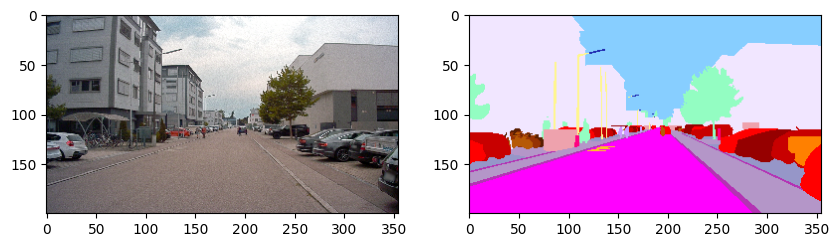

In [31]:
# visualizzo un immagine e la sua label di esempio
img = Image.open(camera_path + camera_imgs_list_names[0])
img = np.asarray(img)
label = Image.open(label_path + label_imgs_list_names[0])
label = np.asarray(label)

plt.figure(figsize=(10,15))
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(label)
plt.show()

#### Check valori univoci label, ci sarà marmellata?

numero di buchi:  0


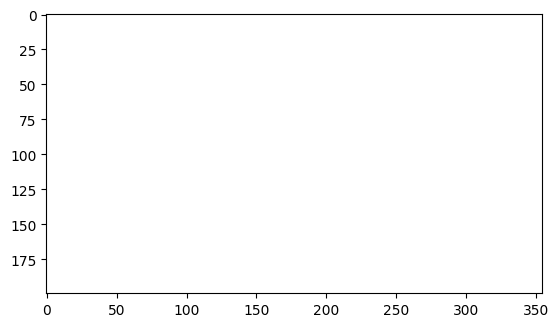

In [32]:
with Image.open(label_path + label_imgs_list_names[0]) as label:
    label = np.array(label)
    hoes_label = np.zeros((label.shape[0], label.shape[1], 3))
    pixels_sbagliati = 0

    for i in range(label.shape[0]):
        for j in range(label.shape[1]):
            colore_pixel_corrente = "#%02x%02x%02x" % (label[i, j, 0], label[i, j, 1], label[i, j, 2])
            if colore_pixel_corrente in colori_classi_label_hex.keys():
                hoes_label[i, j, :] = 1
            else:
                hoes_label[i, j, :] = 0
                pixels_sbagliati += 1

    print("numero di buchi: ", pixels_sbagliati)
    plt.imshow(hoes_label)

YUPPIE

#### Generatore

In [33]:
def generatore_batch_immagini(camera_path, label_path, camera_imgs_list_names, label_imgs_list_names, batch_size):
    '''Generatore che restituisce un batch di immagini e le rispettive label

    Parametri
    ----------
    camera_path : string
        path della cartella contenente le immagini della camera
    label_path : string
        path della cartella contenente le immagini della label
    camera_imgs_list_names : list
        lista contenente i nomi delle immagini della camera
    label_imgs_list_names : list
        lista contenente i nomi delle immagini della label
    batch_size : int
        dimensione del batch di immagini che vogliamo ottenere

    Yields
    ------
    camera_batch : numpy array
        batch di immagini della camera
    label_batch : numpy array
        batch di immagini della label
    '''
    buffer = batch_size
    dimensione_output = (256,256)

    #shuffle delle liste

    for i in range(0, len(camera_imgs_list_names), buffer):
        
        #gestisco il caso in cui l'ultimo batch non sia completo
        if i + buffer > len(camera_imgs_list_names):
            i = len(camera_imgs_list_names) - buffer

        camera_batch = []
        label_batch = []
        for j in range(i, i + buffer):
            with Image.open(camera_path + camera_imgs_list_names[j]) as camera:
                camera = np.array(camera)
                # Data augmentation, agendo solo sul colore, contrasto, luminosità saturazione

                camera = tf.image.random_brightness(camera, 0.3)
                camera = tf.image.random_contrast(camera, 0.8, 1.2)
                camera = tf.image.random_saturation(camera, 0.8, 1.4)

                #normalizzo i valori dei pixel
                camera = camera / 255
                # faccio si che la camera abbia shape (200, 318, 3)
                camera = camera[:, :, :3]

                # faccio il resize della camera
                camera = tf.image.resize(camera, dimensione_output, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

            with Image.open(label_path + label_imgs_list_names[j]) as label:
                label = np.array(label)
                #normalizzo i valori dei pixel
                #label = label / 255
                # faccio si che la label abbia shape (200, 355, 3)
                label = label[:, :, :3]

                #_______________________________________________________
                # creo la label onehot, con shape (200, 355, 1) e valori da 0 a n_classi
                # 0 = pixel macellati
                # 1-n_classi = pixel corrispondenti alle classi
                #_______________________________________________________

                # Creo la label onehot

                label_onehot = np.zeros((label.shape[0], label.shape[1], n_classi), dtype=np.uint8)
                pixel_sbagliati = 0
                # Converte i pixel da colore a encodig per classe
                for row in range(label.shape[0]):
                    for col in range(label.shape[1]):
                        class_idx_trovato = None
                        pixel_color = tuple(label[row, col])
                        pixel_color = '#{:02X}{:02X}{:02X}'.format(pixel_color[0], pixel_color[1], pixel_color[2]).lower()
                        if str(pixel_color) in colori_classi_label_hex:
                            label_name = colori_classi_label_hex[pixel_color]
                            class_idx_trovato = onehot_colori[label_name]
                        for i in range(0, n_classi-1):
                            if i == class_idx_trovato:
                                label_onehot[row, col, i] = 1
                            else:
                                label_onehot[row, col, i] = 0

                label = label_onehot

                # faccio il resize della label
                label = tf.image.resize(label, dimensione_output, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

            camera_batch.append(camera)
            label_batch.append(label)
        yield np.array(camera_batch), np.array(label_batch)

Vedemo che spara sto generatore

0it [00:00, ?it/s]

label_batch[i].shape:  (256, 256, 55)
label_batch[i][0,0,:]:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
label_batch[i].shape:  (256, 256, 55)
label_batch[i][0,0,:]:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
label_batch[i].shape:  (256, 256, 55)
label_batch[i][0,0,:]:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
shape camera_batch:  (3, 256, 256, 3)
shape label_batch:  (3, 256, 256, 55)
max camera_batch:  0.96862745
min camera_batch:  0.0
max label_batch:  1
min label_batch:  0
numero di classi label_batch:  2


0it [00:02, ?it/s]

valori unici label_batch:  [0 1]
nomi classi label_batch:  ['Car 1', 'Car 2']


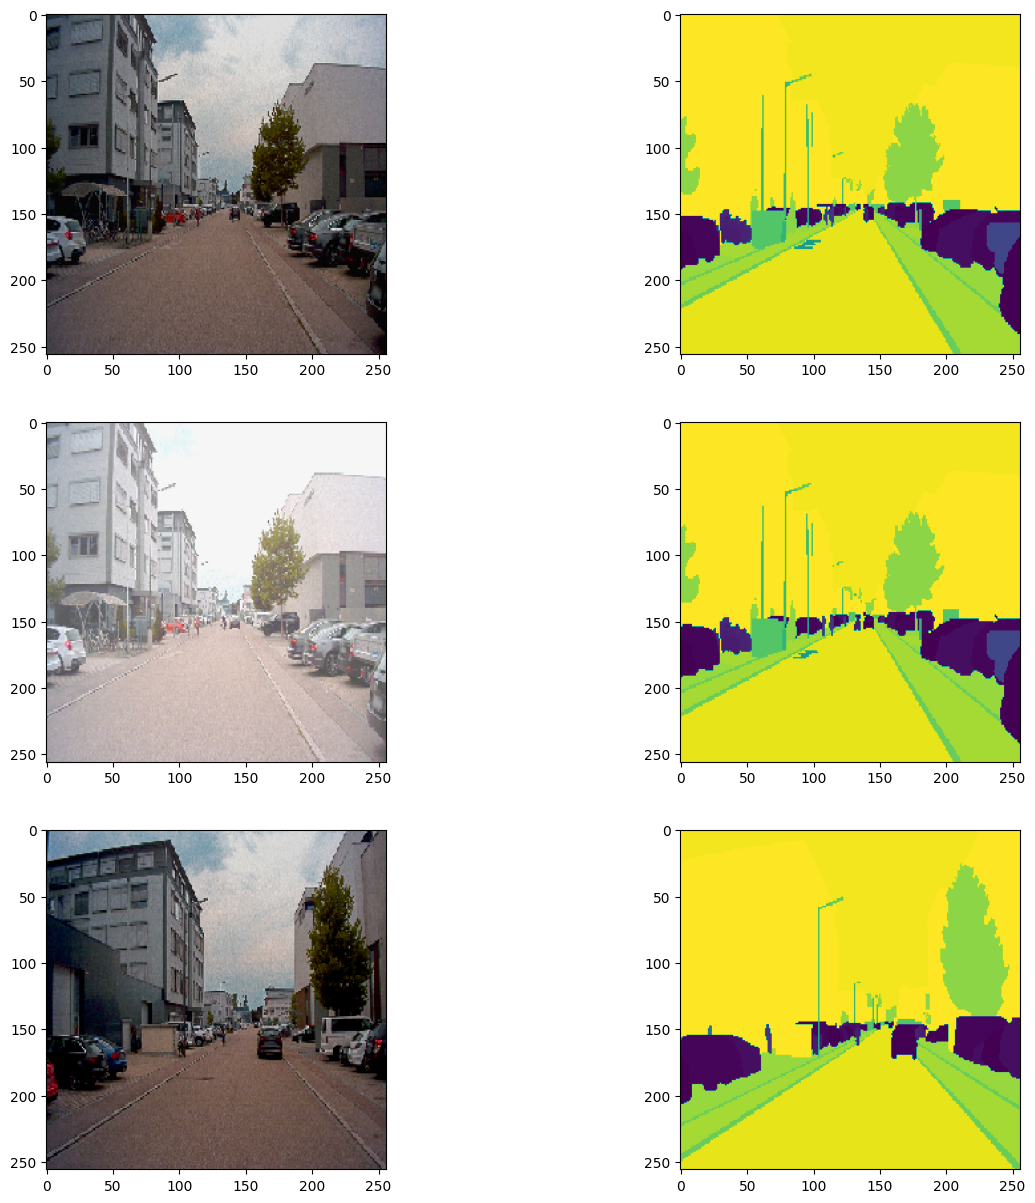

In [34]:
# testiamo il generatore
plt.figure(figsize=(15, 15))
for camera_batch, label_batch in tqdm(generatore_batch_immagini(camera_path, label_path, camera_imgs_list_names, label_imgs_list_names, 3)):
    #mostro le immagini e le rispettive label
    for i in range(3):
        plt.subplot(3, 2, i * 2 + 1)
        plt.imshow(camera_batch[i])
        plt.subplot(3, 2, i * 2 + 2)
        print("label_batch[i].shape: ", label_batch[i].shape)
        print("label_batch[i][0,0,:]: ", label_batch[i][0,0,:] )
        plt.imshow(label_batch[i].argmax(axis=-1),)
    print("shape camera_batch: ", camera_batch.shape)
    print("shape label_batch: ", label_batch.shape)
    print("max camera_batch: ", camera_batch.max())
    print("min camera_batch: ", camera_batch.min())
    print("max label_batch: ", label_batch.max())
    print("min label_batch: ", label_batch.min())
    print("numero di classi label_batch: ", len(np.unique(label_batch)))
    print("valori unici label_batch: ", np.unique(label_batch))

    #voglio sapere che nomi hanno le classi della label_batch, devo quindi convertire i valori da 0 a n_classi in stringhe tramite il dizionario onehot_colori
    # il dizionario onehot_colori ha come chiavi i nomi delle classi e come valori i valori da 1 a n_classi
    # converto i valori unici della label_batch da 0 a 1 al range 0 n_classi
    # li converto in interi
    label_batch = label_batch
    valori_unici = np.unique(label_batch)
    valori_unici = valori_unici.astype(int)

    # creo una lista che conterrà i nomi delle classi
    nomi_classi = []
    for valore in valori_unici:
        if valore in onehot_colori.values():
            # se il valore è presente nel dizionario onehot_colori, prendo la chiave
            nomi_classi.append(list(onehot_colori.keys())[list(onehot_colori.values()).index(valore)])

    print("nomi classi label_batch: ", nomi_classi)

    break

Perfetto Tutto Funziona, tempo di definire i datasets con tensorflow

In [35]:
# train: 80%
# validation: 10%
# test: 10%

n_immagini = len(camera_imgs_list_names)
n_train = int(n_immagini * 0.94)
n_val = int(n_immagini * 0.05)
n_test = int(n_immagini * 0.01)

# creo le liste dei nomi delle immagini
train_camera_imgs_list_names = camera_imgs_list_names[:n_train]
train_label_imgs_list_names = label_imgs_list_names[:n_train]

val_camera_imgs_list_names = camera_imgs_list_names[n_train:n_train+n_val]
val_label_imgs_list_names = label_imgs_list_names[n_train:n_train+n_val]

test_camera_imgs_list_names = camera_imgs_list_names[n_train+n_val:]
test_label_imgs_list_names = label_imgs_list_names[n_train+n_val:]

# creo i dataset
trainset = tf.data.Dataset.from_generator(
    generatore_batch_immagini,
    args=(camera_path, label_path, train_camera_imgs_list_names, train_label_imgs_list_names, batch_size),
    output_signature=(
        tf.TensorSpec(shape=(batch_size, 256, 256, 3)),  # Immagine della camera
        tf.TensorSpec(shape=(batch_size, 256, 256, n_classi)),  # Immagine label
    )
)

valset = tf.data.Dataset.from_generator(
    generatore_batch_immagini,
    args=(camera_path, label_path, val_camera_imgs_list_names, val_label_imgs_list_names, batch_size),
    output_signature=(
        tf.TensorSpec(shape=(batch_size, 256, 256, 3)),  # Immagine della camera
        tf.TensorSpec(shape=(batch_size, 256, 256, n_classi)),  # Immagine label
    )
)

testset = tf.data.Dataset.from_generator(
    generatore_batch_immagini,
    args=(camera_path, label_path, test_camera_imgs_list_names, test_label_imgs_list_names, batch_size),
    output_signature=(
        tf.TensorSpec(shape=(batch_size, 256, 256, 3)),  # Immagine della camera
        tf.TensorSpec(shape=(batch_size, 256, 256, n_classi)),  # Immagine label
    )
)

# trainset = trainset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
# valset = valset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
# testset = testset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)



#trainset = trainset.cache() # cache the dataset to memory to get a speedup while reading from it.


print("Ntest: ", len(test_camera_imgs_list_names))
print("Nval: ", len(val_camera_imgs_list_names))
print("Ntrain: ", len(train_camera_imgs_list_names))

Ntest:  400
Nval:  1996
Ntrain:  37537


shape camera_batch:  (50, 256, 256, 3)
shape label_batch:  (50, 256, 256, 55)
numero di classi label_batch:  2
valori unici label_batch:  [0. 1.]


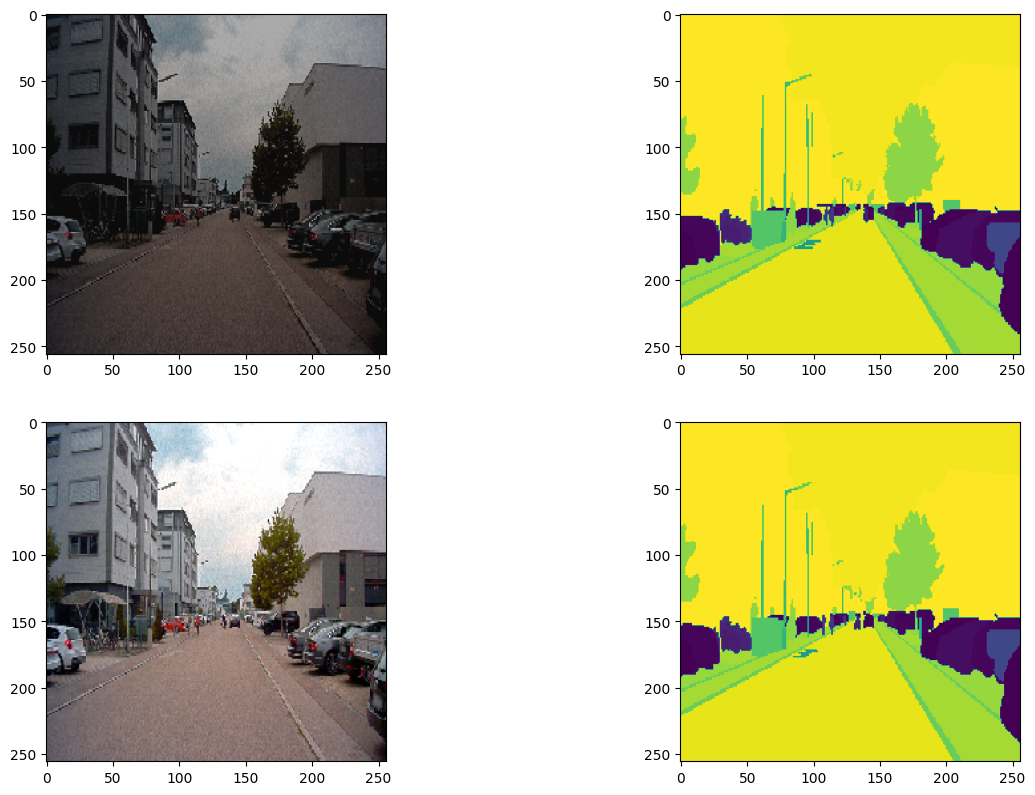

In [36]:
# testiamo i dataset
plt.figure(figsize=(15, 15))
for camera_batch, label_batch in trainset.take(1):
    #mostro le immagini e le rispettive label
    for i in range(2):

        plt.subplot(3, 2, i * 2 + 1)
        plt.imshow(camera_batch[i])
        plt.subplot(3, 2, i * 2 + 2)
        plt.imshow(tf.argmax(label_batch[i],axis=-1))
    print("shape camera_batch: ", camera_batch.shape)
    print("shape label_batch: ", label_batch.shape)
    print("numero di classi label_batch: ", len(np.unique(label_batch)))
    print("valori unici label_batch: ", np.unique(label_batch))
    break


## Callbacks

In [37]:
checkpoint_dir = "checkpoint/"

if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

checkpoint_path = checkpoint_dir + "modello.ckpt"

checkpoint = ModelCheckpoint(checkpoint_path,
                             monitor='val_loss',  # Metrica da monitorare per la perdita
                             save_best_only=True,  # Salva solo i pesi migliori
                             mode='min',  # Minimizza la perdita
                             verbose=1) # Stampa un messaggio per mostrare che il salvataggio è avvenuto

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

def schedule_learning_rate(epoch, lr):
    if epoch < 10:
        return lr  # Tasso di apprendimento iniziale
    else:
        return lr * tf.math.exp(-0.1)  # Riduci il tasso di apprendimento ad ogni epoca successiva

lr_scheduler = LearningRateScheduler(schedule_learning_rate)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.001) #factror è il fattore di riduzione del tasso di apprendimento

callbacks = [checkpoint, early_stopping, lr_scheduler, reduce_lr]

## Pesiamo le classi

## Modelli

### RES-NET

In [15]:
class ResBlock(keras.Model):
    def __init__(self,num_hidden):
        super().__init__()
        self.conv1 = keras.layers.Conv2D(num_hidden, kernel_size = 3, padding = "same")
        self.bn1 = keras.layers.BatchNormalization()
        self.conv2 = keras.layers.Conv2D(num_hidden, kernel_size = 3, padding = "same")
        self.bn2 = keras.layers.BatchNormalization()
        
    def call(self, x):
        residui = x
        x = tf.nn.relu(self.bn1(self.conv1(x))) #il valore di input del "blocco" passa per "conv1", il suo output passa per bn1 (normalizza il batch, ossia li porta tra 0 e 1) e infine passa per la relu
        x = self.bn2(self.conv2(x))
        x += residui # questa è la skip connection (sommiamo l'input con l'output del blocco) # quindi l'insieme di filtri (batch x dimensione x dimensione x dim filtri)
        return tf.nn.relu(x)

    
class ResNet(keras.Model):
    def __init__(self, n_blocchi, n_hidden):
        super().__init__()
        self.start_block = keras.Sequential([
            keras.layers.Conv2D(n_hidden, kernel_size = 3, padding = "same"),
            keras.layers.BatchNormalization(),
            keras.layers.ReLU()])
        self.back_bone = [ResBlock(n_hidden) for _ in range(n_blocchi)] # l'insieme di tutti i ResBlock
        self.fine = keras.Sequential([
            keras.layers.Conv2D(n_classi, kernel_size = 3, padding = "same"),
            keras.layers.BatchNormalization(),
            keras.layers.Softmax()]) # output della rete
    
    def call(self, x):
        x = self.start_block(x)
        for resblock in self.back_bone:
            x = resblock(x)
        risultato_rete = self.fine(x)
    
        return risultato_rete
    

In [16]:
with strategy.scope():
    model_resnet = ResNet(n_blocchi = 15, n_hidden = 64)

In [17]:
def recall_m(y_true, y_pred):
    true_positives = keras.backend.sum(keras.backend.round(keras.backend.clip(y_true * y_pred, 0, 1)))
    possible_positives = keras.backend.sum(keras.backend.round(keras.backend.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + keras.backend.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = keras.backend.sum(keras.backend.round(keras.backend.clip(y_true * y_pred, 0, 1)))
    predicted_positives = keras.backend.sum(keras.backend.round(keras.backend.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + keras.backend.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    f1 = 2*((precision*recall)/(precision+recall+keras.backend.epsilon()))
    #keras.backend.clear_session()
    return f1
    

In [18]:
with strategy.scope():
    model_resnet.compile(optimizer='adam', loss=CategoricalCrossentropy(), metrics=["accuracy"])
    model_resnet.build((None,256,256,3))

In [19]:
model_resnet.summary()

Model: "res_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 64)      2048      
                                                                 
 res_block (ResBlock)        multiple                  74368     
                                                                 
 res_block_1 (ResBlock)      multiple                  74368     
                                                                 
 res_block_2 (ResBlock)      multiple                  74368     
                                                                 
 res_block_3 (ResBlock)      multiple                  74368     
                                                                 
 res_block_4 (ResBlock)      multiple                  74368     
                                                                 
 res_block_5 (ResBlock)      multiple                  7436

In [38]:
model_resnet.load_weights("152_epoch_weights_256x256.keras")

In [21]:
with strategy.scope():
    model_resnet.fit(x=trainset, epochs=152, validation_data=valset, initial_epoch=152)

Epoch 151/152
3129/3129 [==============================] - 136867s 44s/step - loss: 0.8443 - accuracy: 0.7778 - val_loss: 1.1044 - val_accuracy: 0.7018
Epoch 152/152
3129/3129 [==============================] - 135527s 43s/step - loss: 0.6992 - accuracy: 0.8117 - val_loss: 1.2386 - val_accuracy: 0.6842


In [22]:
# salvo i pesi della resnet
model_resnet.save_weights("152_epoch_weights_256x256.keras")

In [23]:
testset = testset.shuffle(buffer_size=100)

2/2 [==============================] - 39s 15s/step


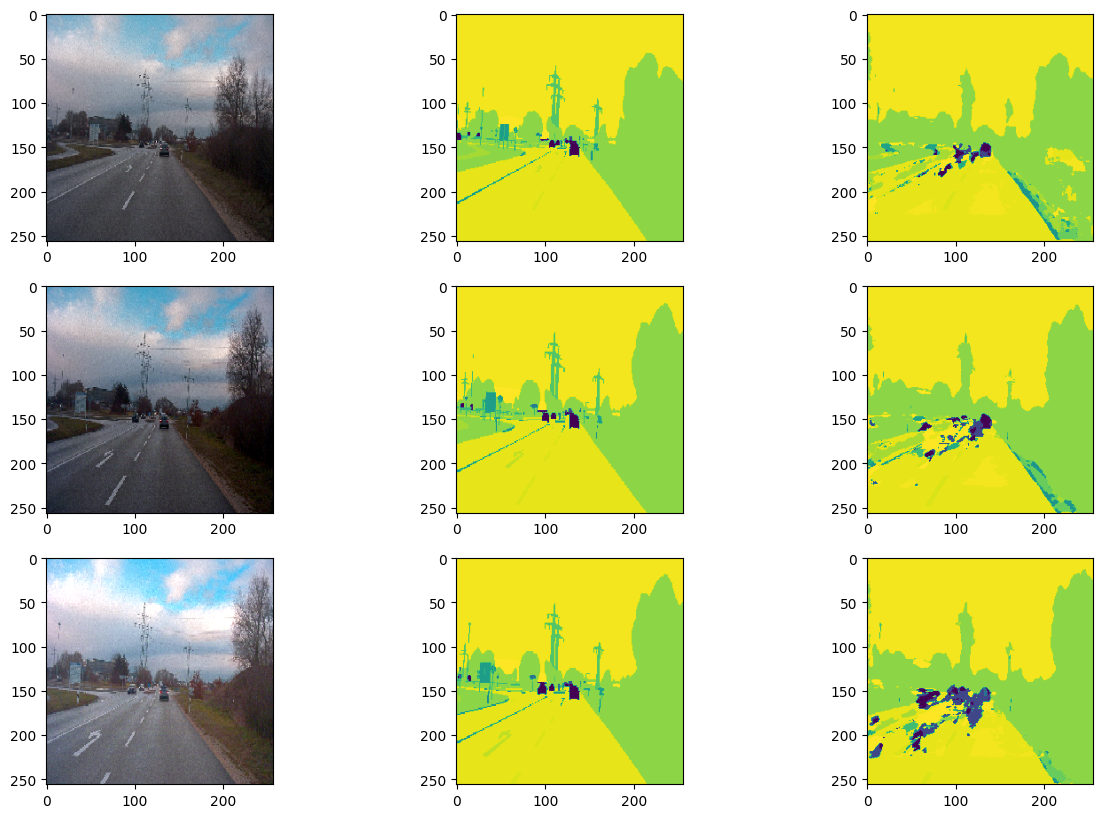

In [39]:
#visualizzo le predizioni
plt.figure(figsize=(15, 10))
for camera_batch, label_batch in testset.take(1):
    prediction = model_resnet.predict(camera_batch)
    for i in range(3):
        plt.subplot(3, 3, i * 3 + 1)
        plt.imshow(camera_batch[i])
        plt.subplot(3, 3, i * 3 + 2)
        plt.imshow(tf.argmax(label_batch[i],axis=-1))
        # riutilizzo il dizionario onehot per comprimere i 56 canali in 1
        plt.subplot(3, 3, i * 3 + 3)
        plt.imshow(tf.argmax(prediction[i],axis=-1))
    break

### unet

In [25]:
class MyUnet(Model):
    def __init__(self, n_filters, n_classes):
        super().__init__()
        self.n_filters = n_filters
        self.down_conv = []
        self.up_conv = []

        self.max_pooling = MaxPool2D(data_format="channels_last")

        # down-section
        for n_filter in n_filters:
            self.down_conv.append(Conv2D(filters=n_filter, kernel_size=5, activation="relu", padding="same"))
            self.down_conv.append(Conv2D(filters=n_filter, kernel_size=3, activation="relu", padding="same"))

        # up-section
        for n_filter in reversed(n_filters):
            self.up_conv.append(Conv2DTranspose(filters=n_filter, kernel_size=2, strides=2, padding="same", activation="relu"))
            self.up_conv.append(Conv2D(filters=n_filter, kernel_size=3, padding="same", activation="relu"))

        self.last_conv = Conv2D(filters=n_classes, kernel_size=1, activation="softmax")

    def call(self, x):
        skips = []
        num_downsteps = len(self.down_conv) // 2

        # down part
        for i in range(num_downsteps):
            x = self.down_conv[2*i](x)
            x = self.down_conv[2*i+1](x)
            skips.append(x)
            x = self.max_pooling(x)

        # up part
        for i in range(num_downsteps):
            x = self.up_conv[2*i](x)
            skip = skips.pop()
            if x.shape[1:3] != skip.shape[1:3]:
                # Applica il padding personalizzato                                           #qui avvengono le magie di controllo della shape tra un layer e l'altro
                height_diff = skip.shape[1] - x.shape[1]                                      #qui avvengono le magie di controllo della shape tra un layer e l'altro
                width_diff = skip.shape[2] - x.shape[2]                                       #qui avvengono le magie di controllo della shape tra un layer e l'altro
                padding = tf.constant([[0, 0], [0, height_diff], [0, width_diff], [0, 0]])    #qui avvengono le magie di controllo della shape tra un layer e l'altro
                x = tf.pad(x, padding, "CONSTANT")                                            #qui avvengono le magie di controllo della shape tra un layer e l'altro
            x = x + skip                                                                      #qui avvengono le magie di controllo della shape tra un layer e l'altro
            x = self.up_conv[2*i+1](x)                                                        #qui avvengono le magie di controllo della shape tra un layer e l'altro


        return self.last_conv(x)

In [26]:
with strategy.scope():
    unet = MyUnet(n_filters=[32, 64, 128, 128, 256, 256], n_classes=n_classi)

In [27]:
with strategy.scope():
   unet.compile(optimizer='adam', loss=CategoricalCrossentropy(), metrics=["accuracy"])

In [40]:
with strategy.scope():
    unet.fit(x=trainset, epochs=5, validation_data=valset, initial_epoch=3)

Epoch 4/5
    339/Unknown - 15150s 45s/step - loss: 1.6669 - accuracy: 0.5250

In [ ]:
# salvo i pesi della unet
unet.save_weights("full_dataset_50_unet_weights_256x256.keras")

1/1 [==============================] - 1s 732ms/step


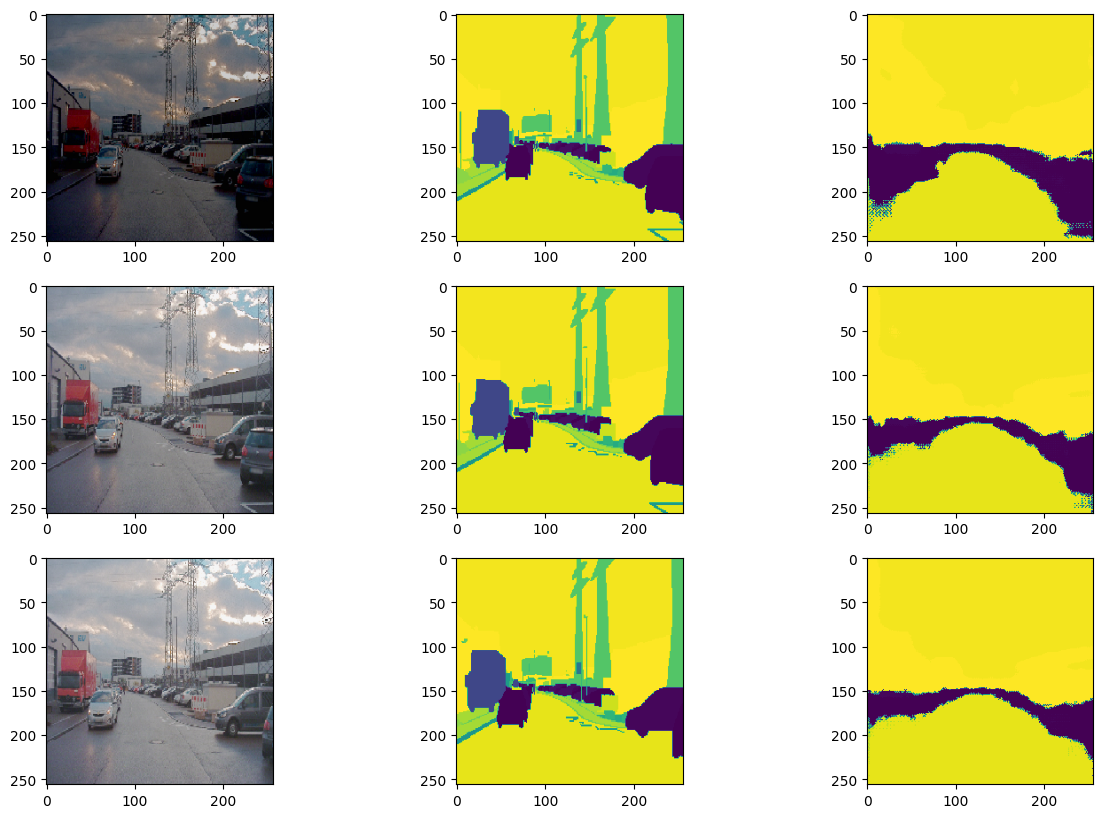

In [ ]:
#visualizzo le predizioni
plt.figure(figsize=(15, 10))
testset = testset.shuffle(buffer_size=100)
for camera_batch, label_batch in testset.take(1):
    prediction = unet.predict(camera_batch)
    for i in range(3):
        plt.subplot(3, 3, i * 3 + 1)
        plt.imshow(camera_batch[i])
        plt.subplot(3, 3, i * 3 + 2)
        plt.imshow(tf.argmax(label_batch[i],axis=-1))
        # riutilizzo il dizionario onehot per comprimere i 56 canali in 1
        plt.subplot(3, 3, i * 3 + 3)
        plt.imshow(tf.argmax(prediction[i],axis=-1))
    break

### Convolutional

#### Fa schifo
- necessita di una soluzione per la pedita del gradiente
- necessita di una custom loss per compensare lo sbilanciamento delle classi (es troppo cielo, strada, alberi, e pochi cartelli, pedoni etc etc)

In [ ]:
with strategy.scope():
    modello_convoluzionale = Sequential([
        #Resizing(256, 256, interpolation="nearest"),
        # downpart
        Conv2D(64, 3, padding='same', activation='relu'),
        Conv2D(64, 3, padding='same', activation='relu'),
        MaxPooling2D(),
        Conv2D(128, 3, padding='same', activation='relu'),
        Conv2D(128, 3, padding='same', activation='relu'),
        MaxPooling2D(),
        Conv2D(256, 3, padding='same', activation='relu'),
        Conv2D(256, 3, padding='same', activation='relu'),
        Conv2D(256, 3, padding='same', activation='relu'),
        MaxPooling2D(),
        # uppart
        UpSampling2D(),
        Conv2D(256, 3, padding='same', activation='relu'),
        Conv2D(256, 3, padding='same', activation='relu'),
        Conv2D(256, 3, padding='same', activation='relu'),
        UpSampling2D(),
        Conv2D(128, 3, padding='same', activation='relu'),
        Conv2D(128, 3, padding='same', activation='relu'),
        UpSampling2D(),
        Conv2D(64, 3, padding='same', activation='relu'),
        Conv2D(64, 3, padding='same', activation='relu'),
        #Conv2D(1, 3, padding='same', activation='softmax'),
        #Conv2DTranspose(1, 3, padding='same'),  # NON FUNZIONA - Se lo togli e metti from_logits=True in SparseCategoricalCrossentropy funziona
        #Resizing(200, 355, interpolation='nearest'),
        Conv2D(n_classi, 1, activation='softmax')
        #Dense(n_classi, activation='softmax')  # lo strato dense con il n definisce il numero di neuroni, devono essere n_classi perchè abbiamo n_classi classi, e ritorna 1 valore per ogni classe nella terza dimensione delle label
    ])

    modello_convoluzionale.build(input_shape=(None, 256, 256, 3))
    modello_convoluzionale.summary()

In [ ]:
with strategy.scope():
    # modello_convoluzionale.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    # modello_convoluzionale.compile(optimizer='adam', loss=SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
    modello_convoluzionale.compile(optimizer='adam', loss=CategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

fai un check per la distributed strategy, ovvero se hai una gpu e esegui i calcoli in parallelo

In [ ]:
# carico il chcekpoint
#modello_convoluzionale.load_weights(checkpoint_path)

In [ ]:
# carico i pesi
#modello_convoluzionale.load_weights("modello_convoluzionale_colab_256.keras")

In [ ]:
with strategy.scope():
    modello_convoluzionale.fit(trainset, epochs=1, validation_data=valset, initial_epoch=0)

In [ ]:
#salvo i pesi
modello_convoluzionale.save_weights("modello_convoluzionale_colab_256_40_epochs.keras")

In [ ]:
#salvo i pesi
#modello_convoluzionale.save_weights("modello_convoluzionale_colab_15_256.keras")

In [ ]:
#visualizzo le predizioni
plt.figure(figsize=(15, 10))
testset = testset.shuffle(buffer_size=100)
for camera_batch, label_batch in testset.take(1):
    prediction = modello_convoluzionale.predict(camera_batch)
    for i in range(3):
        plt.subplot(3, 3, i * 3 + 1)
        plt.imshow(camera_batch[i])
        plt.subplot(3, 3, i * 3 + 2)
        plt.imshow(tf.argmax(label_batch[i],axis=-1))
        # riutilizzo il dizionario onehot per comprimere i 56 canali in 1
        plt.subplot(3, 3, i * 3 + 3)
        plt.imshow(tf.argmax(prediction[i],axis=-1))
    break

### Dense

In [ ]:
with strategy.scope():
    modello_denso_come_il_budino = Sequential([
        # downpart
        Conv2D(64, 3, padding='same', activation='relu'),
        Conv2D(64, 3, padding='same', activation='relu'),
        MaxPooling2D(),
        Conv2D(128, 3, padding='same', activation='relu'),
        Conv2D(128, 3, padding='same', activation='relu'),
        MaxPooling2D(),
        # flatten
        Flatten(),
        # per non ottenere l'errore " ValueError: `labels.shape` must equal `logits.shape` except for the last dimension. Received: labels.shape=(3550000,) and logits.shape=(50, n_classi)" d
        Dense(2000, activation='relu'),
        Dense(500, activation='relu'),
        Dense(200, activation='relu'),
        Dense(n_classi, activation='softmax'),
    ])

    modello_denso_come_il_budino.build(input_shape=(None, 256, 256, 3))
    modello_denso_come_il_budino.summary()

In [ ]:
with strategy.scope():
    modello_denso_come_il_budino.compile(optimizer='adam', loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
with strategy.scope():
    modello_denso_come_il_budino.fit(trainset, epochs=2, validation_data=valset, callbacks=callbacks)

In [ ]:
#visualizzo le predizioni
plt.figure(figsize=(15, 10))
testset = testset.shuffle(buffer_size=100)
for camera_batch, label_batch in testset.take(1):
    for i in range(2):
        plt.subplot(3, 3, i * 3 + 1)
        plt.imshow(camera_batch[i])
        plt.subplot(3, 3, i * 3 + 2)
        plt.imshow(label_batch[i])
        # riutilizzo il dizionario onehot per comprimere i 56 canali in 1
        prediction = modello_denso_come_il_budino.predict(camera_batch[i:i+1])[0]
        prediction = np.argmax(prediction, axis=2) #argmax restituisce l'indice del valore massimo, quindi l'indice della classe
        plt.subplot(3, 3, i * 3 + 3)
        plt.imshow(prediction)
    break

In [ ]:
tf.config.list_physical_devices("GPU")